# Data Preparation

### Imports

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
%matplotlib inline

### Reading the Data

In [2]:
data = pd.read_csv('coursera_data.csv')
data = data.drop('Unnamed: 0', axis=1)

In [3]:
data.head()

,course_title,course_organization,course_Certificate_type,course_rating,course_difficulty,course_students_enrolled
0,(ISC)² Systems Security Certified Practitioner...,(ISC)²,SPECIALIZATION,4.7,Beginner,5.3k
1,A Crash Course in Causality: Inferring Causal...,University of Pennsylvania,COURSE,4.7,Intermediate,17k
2,A Crash Course in Data Science,Johns Hopkins University,COURSE,4.5,Mixed,130k
3,A Law Student's Toolkit,Yale University,COURSE,4.7,Mixed,91k
4,A Life of Happiness and Fulfillment,Indian School of Business,COURSE,4.8,Mixed,320k


### Data Dimensions and Features

In [4]:
data.shape

(891, 6)

In [5]:
list(data.columns)

['course_title',
 'course_organization',
 'course_Certificate_type',
 'course_rating',
 'course_difficulty',
 'course_students_enrolled']

### Checking for Missing Values and Duplicates

In [6]:
data.isna().any().any()

False

In [7]:
data.duplicated().any()

False

There are no duplicates nor missing values.

### Reformatting the Data

The 'course_students_enrolled' column uses the pattern number + (k or m) to denote the number of enrolled students. Here the letter k stands for thousands and m for millions.\
In order to perform numerical operations, it is necessary to reformat this column.

In [8]:
data['course_students_enrolled'].str.endswith('k').all()

False

In [9]:
pd.DataFrame(data[np.invert(data['course_students_enrolled'].str.endswith('k'))]['course_students_enrolled'])

,course_students_enrolled
564,3.2m
674,1.3m
688,1.5m
815,2.5m


In [10]:
k_mask = data['course_students_enrolled'].str.endswith('k')
m_mask = data['course_students_enrolled'].str.endswith('m')
data['course_students_enrolled_numeric'] = pd.concat([
pd.to_numeric(data[k_mask]['course_students_enrolled'].str[:-1]) * 1E3,
pd.to_numeric(data[m_mask]['course_students_enrolled'].str[:-1]) * 1E6]).sort_index()

## Treating Outliers

There are two numerical labels where the outliers need to be aknowledged: __course_rating__ and __course_students_enrolled__.

### Course Rating

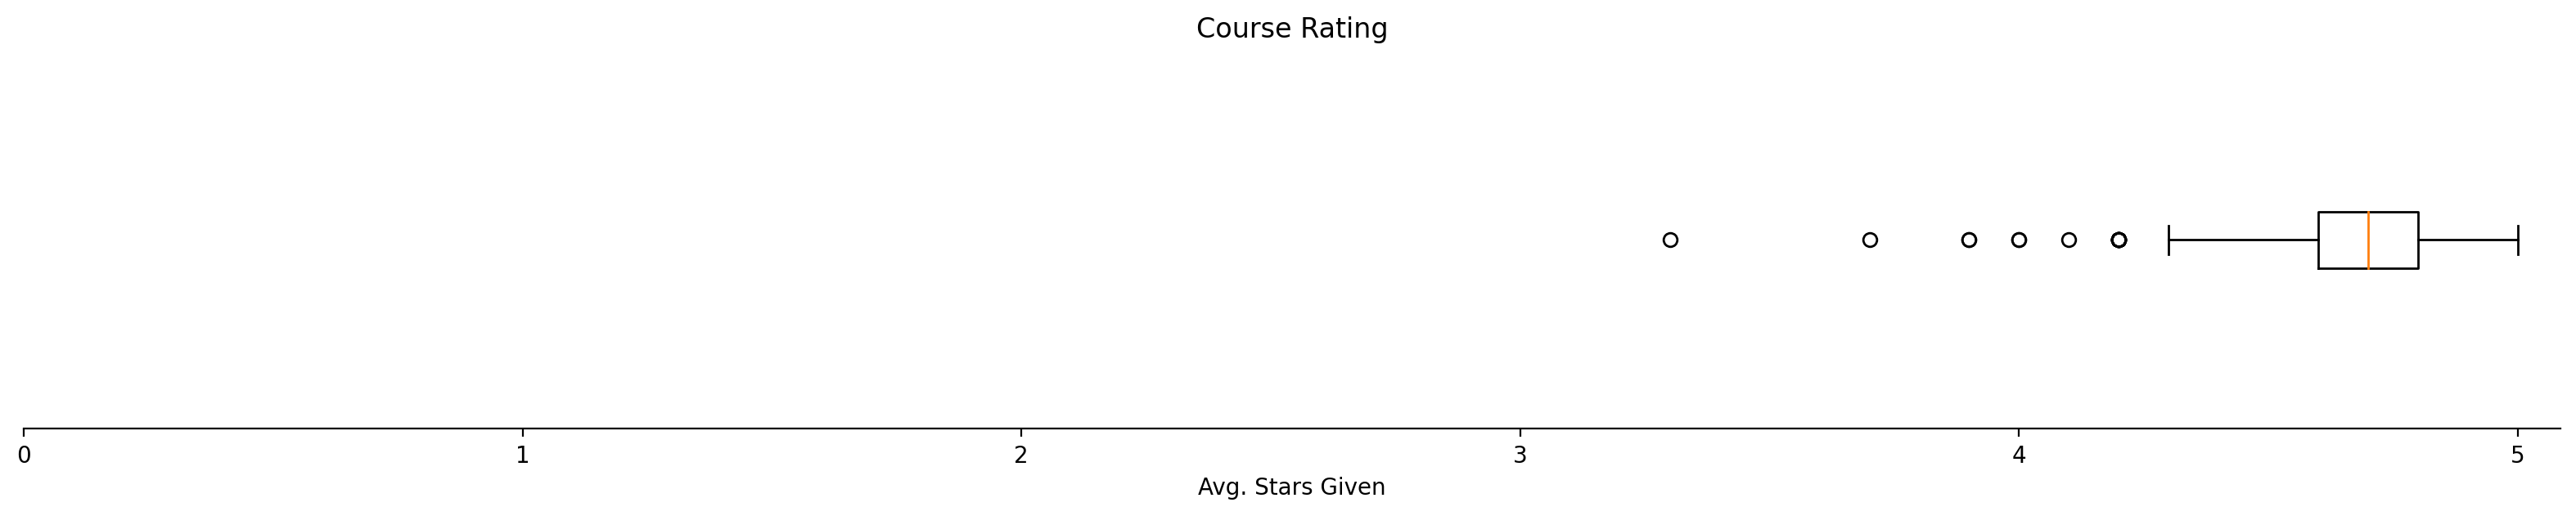

In [11]:
fig = plt.figure(figsize=(20,3), dpi=200)
ax = plt.gca()
ax.boxplot(data['course_rating'],vert=False)
ax.yaxis.set_major_formatter(plt.NullFormatter())
ax.yaxis.set_major_locator(plt.NullLocator())
ax.spines['top'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.set_title('Course Rating')
ax.set_xlabel('Avg. Stars Given')
ax.set_xlim(xmin=0);

While lower outliers are present in this feature, there's no indication that this data is flawed in any manner, as ratings of 3.3 or higher fall within the normal range.

### Course Students Enrolled

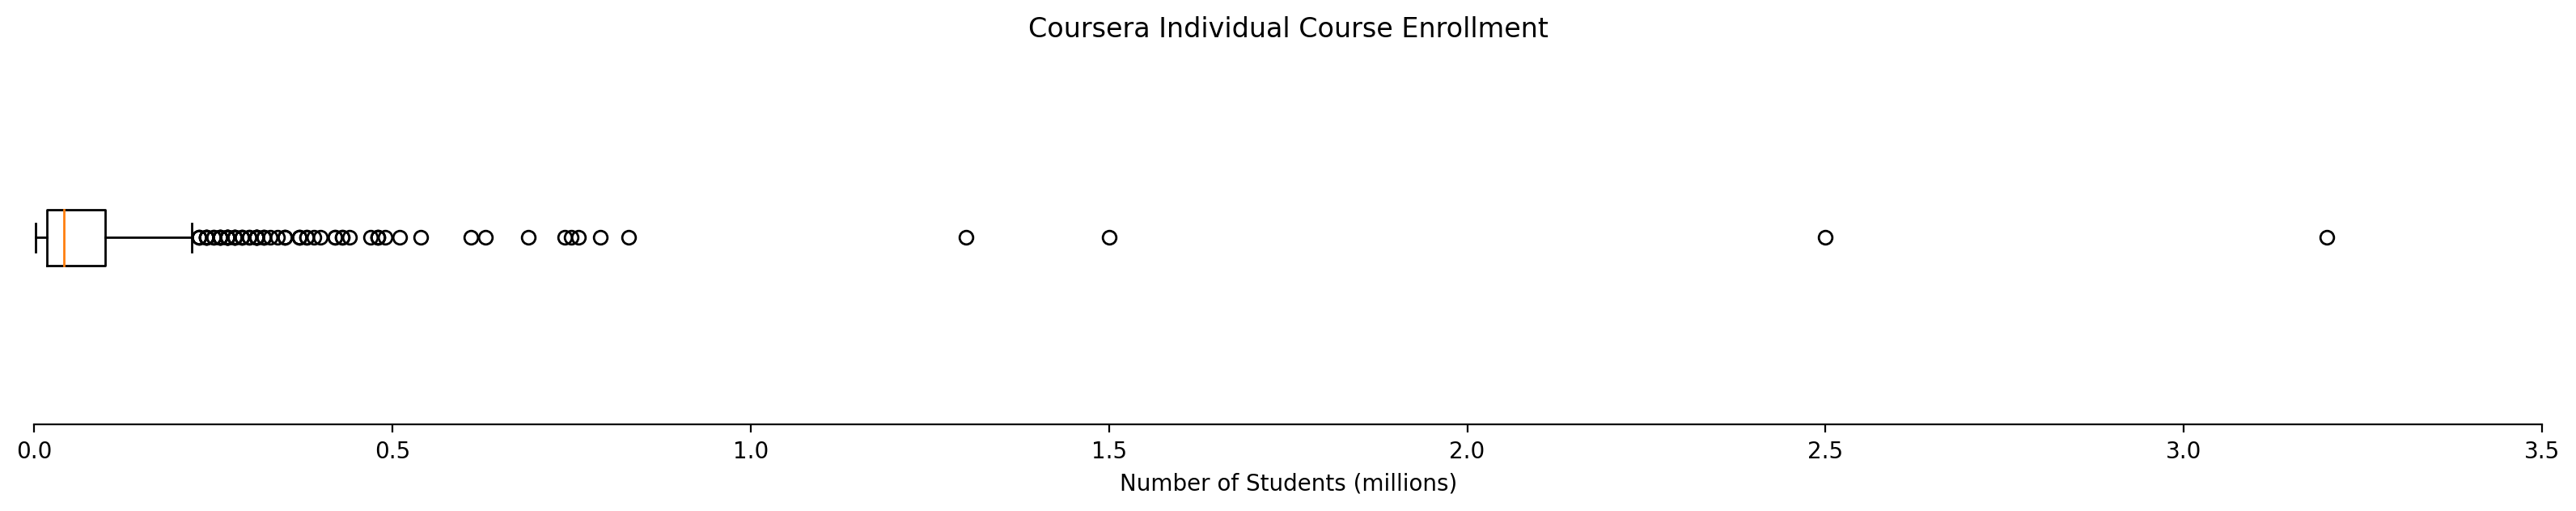

In [16]:
fig = plt.figure(figsize=(20,3),dpi=200)
ax = plt.gca()
ax.boxplot(data['course_students_enrolled_numeric'], vert=False)
ax.yaxis.set_major_formatter(plt.NullFormatter())
ax.yaxis.set_major_locator(plt.NullLocator())
ax.xaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: x / 1E6))
ax.spines['top'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.set_xlabel('Number of Students (millions)')
ax.set_title('Coursera Individual Course Enrollment')
ax.set_xlim(xmin=0, xmax=3.5E6);

In [13]:
q1,q3 = np.percentile(data['course_students_enrolled_numeric'],[25,75])
iqr = q3 - q1
data[data['course_students_enrolled_numeric'] > q3 + (1.5 * iqr)].sort_values(
'course_students_enrolled_numeric', ascending=False).head()

,course_title,course_organization,course_Certificate_type,course_rating,course_difficulty,course_students_enrolled,course_students_enrolled_numeric
564,Machine Learning,Stanford University,COURSE,4.9,Mixed,3.2m,3200000.0
815,The Science of Well-Being,Yale University,COURSE,4.9,Mixed,2.5m,2500000.0
688,Python for Everybody,University of Michigan,SPECIALIZATION,4.8,Beginner,1.5m,1500000.0
674,Programming for Everybody (Getting Started wit...,University of Michigan,COURSE,4.8,Mixed,1.3m,1300000.0
196,Data Science,Johns Hopkins University,SPECIALIZATION,4.5,Beginner,830k,830000.0


There seem to be nothing that would indicate errors in the data. Even among the largest outliers, given the size of Coursera's total users, the prestige of the publishing organizations and the demand for MOOC's (especially for Data Science, ML and Python) such enrollment sizes are probable.

# Exploratory Analysis